In [16]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations

# Add parent directory to path.
from pathlib import Path
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413
fdir = Path(os.path.abspath('')).resolve() # Directory of current file.
path = fdir/'..'
if path not in sys.path:
    sys.path.append(str(path))

# Complete imports.
from functools import partial
import makassar_ml as ml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import seaborn as sns
from sklearn.model_selection import ParameterGrid
sns.set() # Use seaborn themes.

# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    print(f"Name: {gpu.name}, Type: {gpu.device_type}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


In [17]:
# Configure root paths.
config_roots = dict(
    hp_tuning_root=Path('~/research/makassar/hp_tuning').expanduser(),
)

In [18]:
epochs = 30
batch_size = 256

In [19]:
# Load the dataset.
dataset_kwargs = dict(
    path=str(Path('~/research/makassar/datasets/beijing_pm25').expanduser()),
    # in_feat=['pm2.5','TEMP','Iws','Ir'],
    # out_feat=['DEWP','PRES'],
    in_feat=['TEMP','DEWP','PRES','Iws'],
    out_feat=['pm2.5','Ir'],
    # in_seq_len=24*30, # hours
    # in_seq_len=24*7, # hours
    in_seq_len=24, # hours
    out_seq_len=1,
    shift=1,
    split=[0.7,0.2,0.1],
    shuffle=False,
)
dataset_train, dataset_val, dataset_test = ml.datasets.beijingpm25.load_beijingpm25_ds(
    **dataset_kwargs,
    batch_size=batch_size,
)
n_batches = tf.data.experimental.cardinality(dataset_train)
n_steps = n_batches*epochs

In [20]:
for b_x, b_y in dataset_train:
    print(f"{b_x.shape=}")
    print(f"{b_y.shape=}")
    break

for b_x, b_y in dataset_val:
    print(f"{b_x.shape=}")
    print(f"{b_y.shape=}")
    break

for b_x, b_y in dataset_test:
    print(f"{b_x.shape=}")
    print(f"{b_y.shape=}")
    break

b_x.shape=TensorShape([256, 24, 4])
b_y.shape=TensorShape([256, 1, 2])
b_x.shape=TensorShape([256, 24, 4])
b_y.shape=TensorShape([256, 1, 2])
b_x.shape=TensorShape([256, 24, 4])
b_y.shape=TensorShape([256, 1, 2])


In [11]:
print(f"{epochs=}")
print(f"{n_batches=}")
print(f"{n_steps=}")

epochs=30
n_batches=<tf.Tensor: shape=(), dtype=int64, numpy=115>
n_steps=<tf.Tensor: shape=(), dtype=int64, numpy=3450>


In [12]:
# Build and compile the model.
model = ml.models.FoT(
    in_seq_len=dataset_kwargs['in_seq_len'],
    in_feat=len(dataset_kwargs['in_feat']),
    out_feat=len(dataset_kwargs['out_feat']),
    embed_dim=5,
    n_heads=8,
    ff_dim=256,
    dropout=0.1,
    n_encoders=3,
)
# optimizer = keras.optimizers.Adam(learning_rate=1e-3)
# optimizer = keras.optimizers.Adam(
#     keras.experimental.CosineDecayRestarts(
#         initial_learning_rate=1e-3,
#         first_decay_steps=1000,
#         )
# )
learning_rate = keras.experimental.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=n_steps,
    alpha=0.1,
)
# learning_rate = keras.experimental.CosineDecayRestarts(
#     initial_learning_rate=1e-3,
#     first_decay_steps=n_steps//3,
#     m_mul=0.8,
# )
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
metrics = ['mae','mape']
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=metrics,
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 4)]      0                                            
__________________________________________________________________________________________________
time2_vec (Time2Vec)            (None, 24, 20)       528         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 24, 24)       0           input_1[0][0]                    
                                                                 time2_vec[0][0]                  
__________________________________________________________________________________________________
transformer_encoder_layer (Tran (None, 24, 24)       15064       concatenate[0][0]            

(<tf.Tensor: shape=(), dtype=float32, numpy=0.001>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.000100000194>)

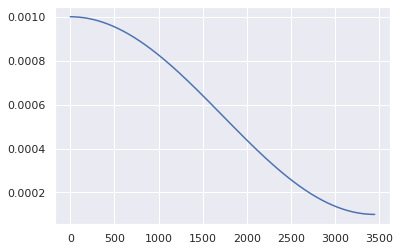

In [13]:
steps = np.arange(n_steps)
lrs = learning_rate(steps)
plt.plot(steps, lrs)
lrs[0],lrs[-1]

In [14]:
# Train.
# strategy = tf.distribute.get_strategy()
history = model.fit(
    dataset_train,
    validation_data=dataset_val,
    epochs=epochs,
    verbose=1,
)

Epoch 1/30
115/115 [==============================] - 6s 25ms/step - loss: 2.1495 - mae: 0.8624 - mape: 469.4475 - val_loss: 1.0086 - val_mae: 0.7030 - val_mape: 357.1342
Epoch 2/30
115/115 [==============================] - 2s 16ms/step - loss: 1.6958 - mae: 0.6796 - mape: 271.0830 - val_loss: 0.8951 - val_mae: 0.5087 - val_mape: 116.3791
Epoch 3/30
115/115 [==============================] - 2s 16ms/step - loss: 1.6861 - mae: 0.6307 - mape: 209.2362 - val_loss: 0.9482 - val_mae: 0.5556 - val_mape: 168.6908
Epoch 4/30
115/115 [==============================] - 2s 16ms/step - loss: 1.7123 - mae: 0.6130 - mape: 183.3219 - val_loss: 0.9373 - val_mae: 0.5415 - val_mape: 151.6132
Epoch 5/30
115/115 [==============================] - 2s 16ms/step - loss: 1.6740 - mae: 0.6141 - mape: 187.5431 - val_loss: 0.8873 - val_mae: 0.5076 - val_mape: 115.9259
Epoch 6/30
115/115 [==============================] - 2s 16ms/step - loss: 1.6483 - mae: 0.5916 - mape: 162.4987 - val_loss: 0.8736 - val_mae: 0.

/tmp/ipykernel_1167/2114538881.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


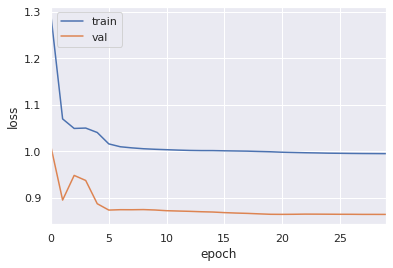

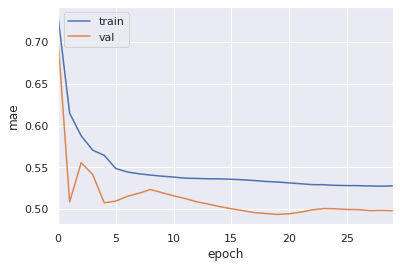

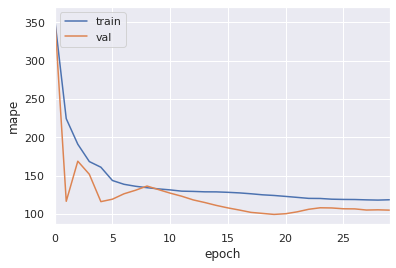

In [15]:
for key in ['loss']+metrics:
    fig = ml.visualization.plot_metric(history.history, key)
    fig.show()